# Genotype data preprocessing
This section documents output from the genotype section (colored in light yellow) of xqtl discovery pipeline MWE and explained the purpose for each of the command. The file used in this page can be found within the protocol_data folder of the synapse repo as described on the landing page.

**For mutli-theme study using same set of genotype (i.e. different tissues for the same participant) , the VCF QC and final Genotype QC steps are ran once. The related/unrelated genotype QC and PCA were ran once per tissue, as only the participant also have molecular phenotype data will be used for PCA**

> ../images/eqtl_command.png (254.4 KiB):

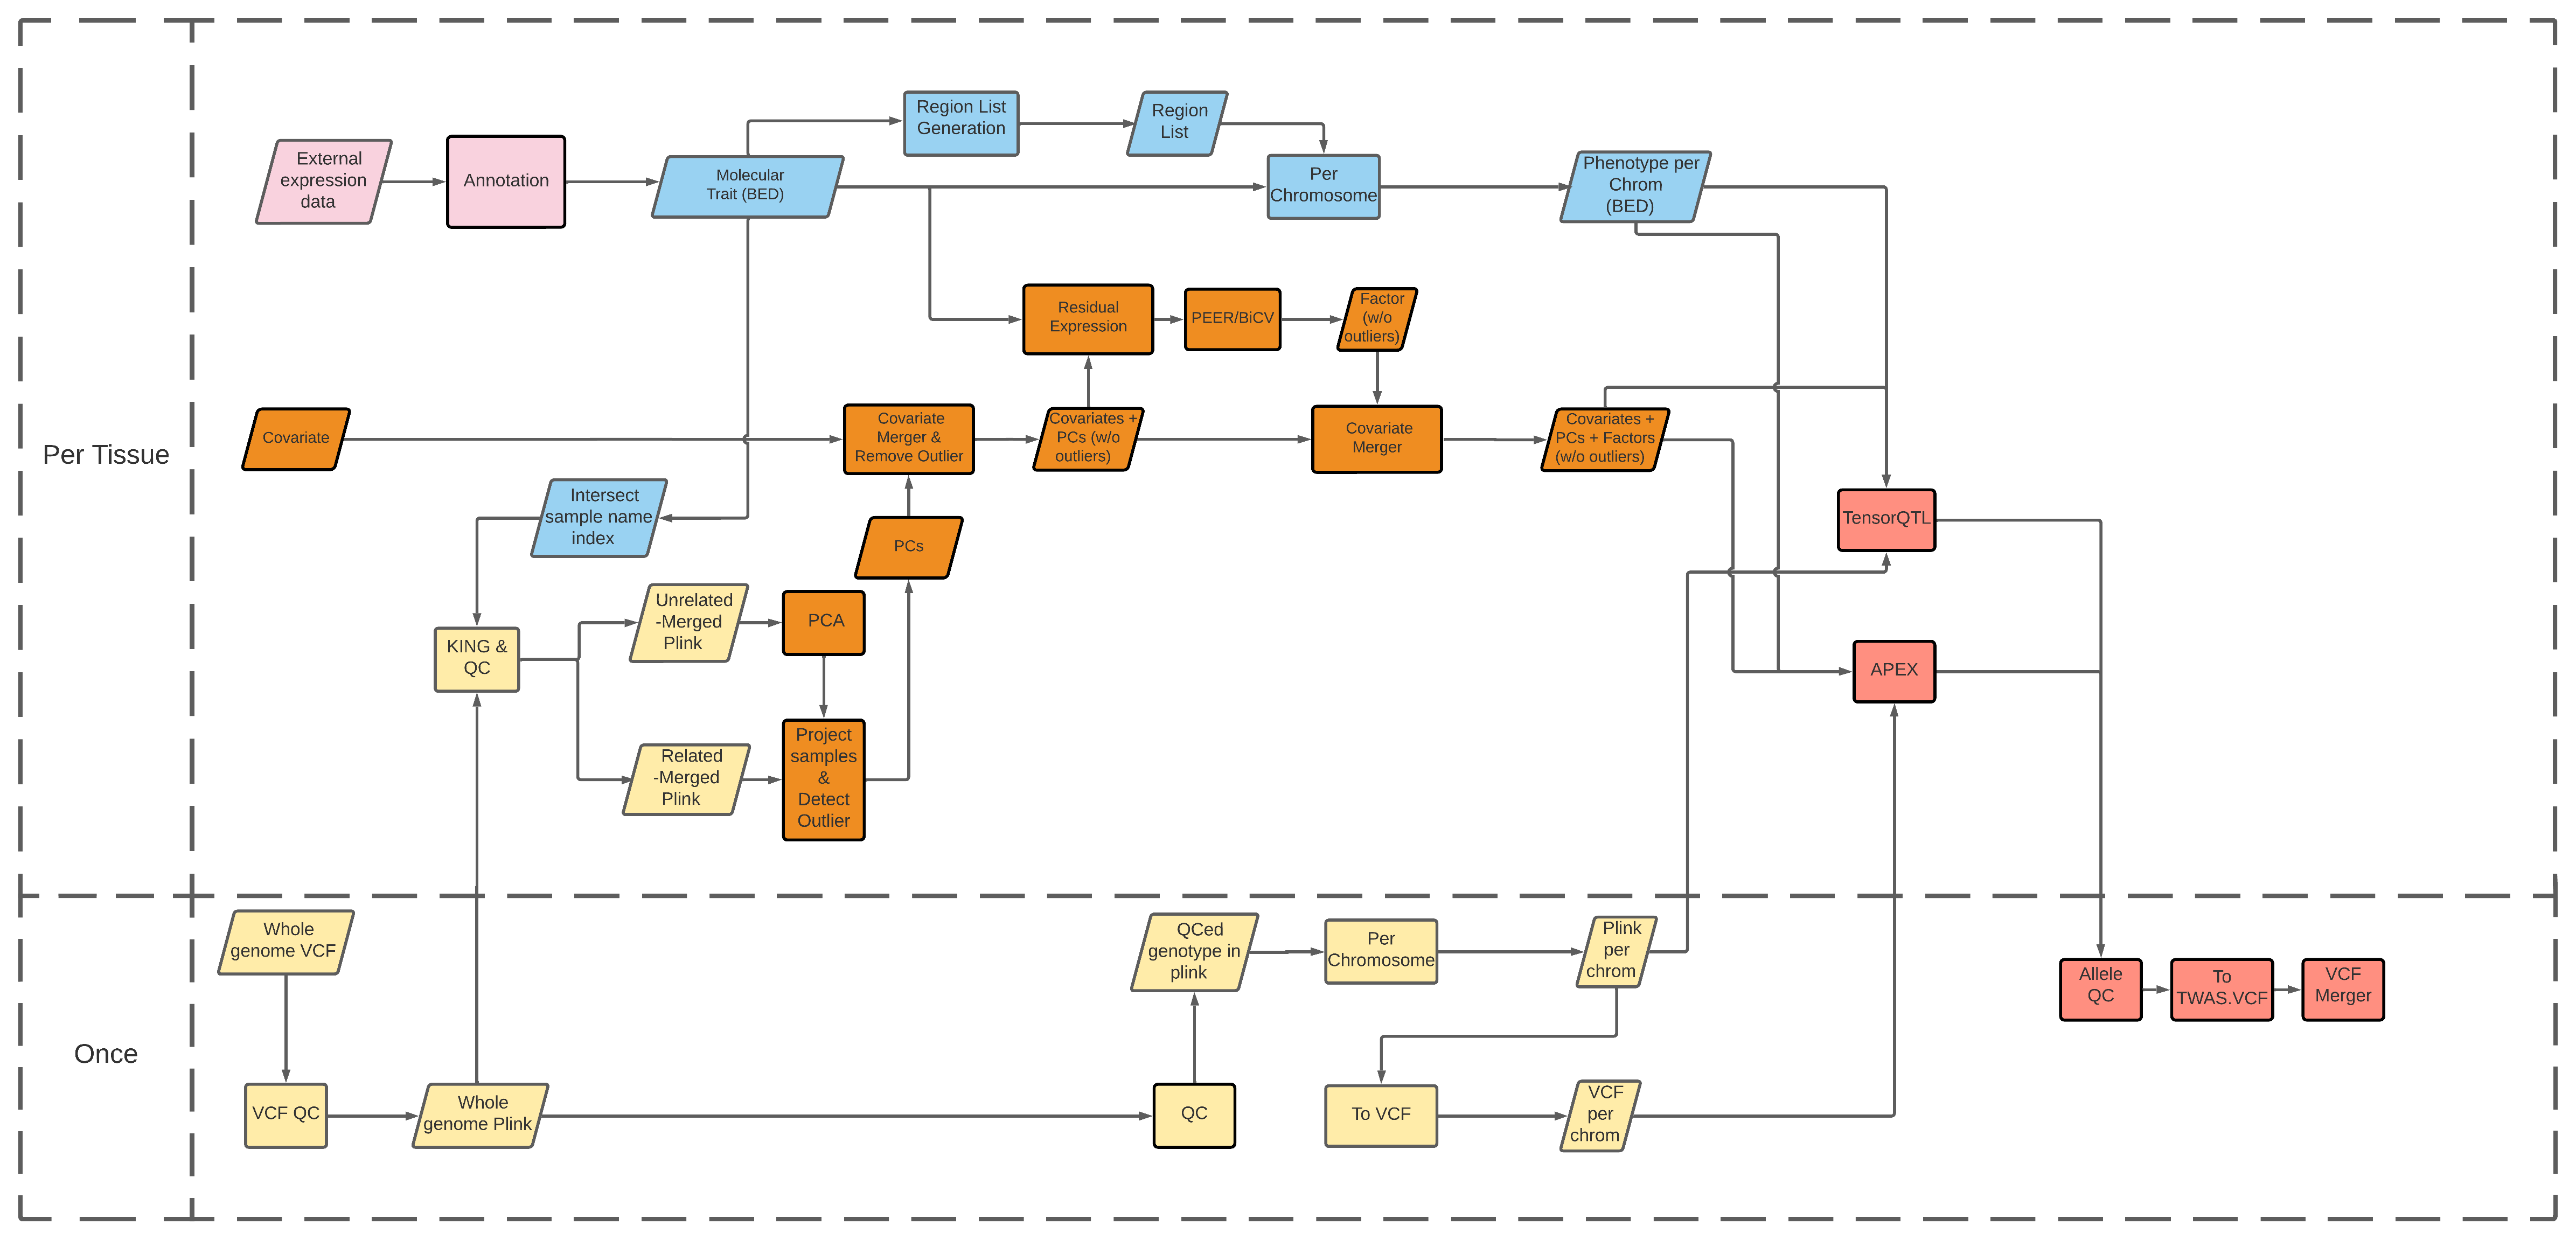

In [1]:
%preview ../images/eqtl_command.png

## Overview

### Analysis steps

1. Genotype data quality control (QC). See here for the [QC default settings](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/GWAS_QC.html).
2. Principle component analysis (PCA) based QC, and PC computation for each sub-population available in the genotype data.
3. Genomic relationship matrix (GRM) computation (optional, when in Step 1 genotype QC detects related individuals or the input is known to have related individuals).

### Input data requirement

1. Genotype data. See here for [format details](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/genotype_formatting.html).
2. [Optional] a sample information file to specific population information, if external data such as HapMap or 1000 Genomes are to be integrated to the PCA analysis to visualize and assess population structure in the genotype data. See here for [format details](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/genotype_formatting.html).

## QC for VCF files

Perform QC on VCF files. The QC-ed data will also be exported to PLINK format for next steps analysis. The QC procedure includes:
1. Handling the formatting of multi-allelic sites, 
2. Genotype and variant level filtering based on genotype calling qualities. 

    2.1. Genotype depth filters: For WES data, UK Biobank recommends **SNPs DP>10 and Indels DP>10 for indels.** However we think for WGS we can be less stringent, or simply rely on GQ. Users can set it to 1 eg, `--DP 1 --DP-indel 1 `

    2.2. Genotype quality GQ>20.

    2.3. At least one sample per site passed the allele balance threshold >= 0.15 for SNPs and >=0.20 for indels (heterozygous variants). Allele balance is calculated for heterozygotes as the number of bases supporting the least-represented allele over the total number of base observations.

3. Known/novel variants annotation
4. Summary statistics before and after QC, in particular the ts/tv ratio, to assess the effectiveness of QC.

3 and 4 above are for explorative analysis on the overall quality assessment of genotype data in the VCF files. We annotate known and novel variants because ts/tv are expected to be different between known and novel variants, and is important QC metric to assess the effectiveness of our QC. 
After the procedure was done, the output will be converted to a plink bed/bim/fam binary format for downstream analysis.

It will take ~25G of memory and ~5min to complete the following step

Resource Usage:
1. Time elapsed: 780s
    chr21 :  400s 
    chr22 :  380s
2. Max Vmem: 20G

In [ ]:
 sos run pipeline/VCF_QC.ipynb qc \
     --genoFile input_data/Genotype/DEJ_11898_B01_GRM_WGS_2017-05-15_21.recalibrated_variants.xqtl_protocol_data.add_chr.vcf.gz \
                input_data/Genotype/DEJ_11898_B01_GRM_WGS_2017-05-15_21.recalibrated_variants.xqtl_protocol_data.add_chr.vcf.gz \
     --dbsnp-variants reference_data/00-All.add_chr.variants.gz \
     --reference-genome reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta \
     --cwd output/data_preprocessing/genotype \
     --container containers/bioinfo.sif \
     --walltime "24h" \
     --add_chr

## Optional: Merged output of VCF QC
To accomodate the genotype file with extra large size,we allow our user to perform QC of vcf file on a per chromomosome basis. However, to accurately perform filtering base on minor allele count, HWE deviation, and missingness, the input to GWAS QC need to be the whole genome genotype file. Therefore we provide this utlity for the user to merge their output from vcf QC

Resource Usage
1. Time elapsed: 13s
2. Max Vmem: 0.8G
    

In [ ]:
 sos run pipeline/genotype_formatting.ipynb merge_plink \
           --genoFile 'output/data_preprocessing/genotype/DEJ_11898_B01_GRM_WGS_2017-05-15_21.recalibrated_variants.xqtl_protocol_data.add_chr.add_chr.leftnorm.filtered.bed' \
                       'output/data_preprocessing/genotype/DEJ_11898_B01_GRM_WGS_2017-05-15_22.recalibrated_variants.xqtl_protocol_data.add_chr.add_chr.leftnorm.filtered.bed' \
           --cwd output/data_preprocessing/genotype \
           --name xqtl_protocol_data.merged \
           --container containers/bioinfo.sif

## Get overlap samples for genotypes and phenotype data
In most of the time, the number of samples in genotype and phenotype data will not be an exact match. Therefore, we provides a utility to produce a list of overlaps samples between genotypes and each phenotypes. Following command retrieve the overlapped sample between Genotypes and methylation data


In [ ]:
sos run pipeline/sample_matcher.ipynb filtered_sample_list \
        --cwd output/  \
        --phenoFile output/methylation/xqtl_protocol_data_arrayMethylation_covariates.sesame.M.bed.gz  \
        --genoFile output/genotype/xqtl_protocol_data.merged.fam  \
        --sample-participant-lookup reference_data/sample_participant_lookup.rnaseq \
        --container containers/bioinfo.sif \
        --translated_phenoFile

## Genotype QC for PCA

To accuratly estimate the PCs for the genotype. We split participants based on their kinship coefficients, estimated by king. We have implemented a graph-based method to avoid removing unrelated participants that are in a family. However, this option is disable by default due to the long running time it required. User can enable this option by changing the `--no-maximize_unrelated` to `--maximize_unrelated`

In [ ]:
sos run pipeline/GWAS_QC.ipynb king \
   --cwd output/pca_methylation \
   --genoFile output/genotype/xqtl_protocol_data.bed \
   --keep-samples output/sample_participant_lookup.filtered_geno.txt \
   --container containers/bioinfo.sif \
   --walltime 48h   --no-maximize_unrelated

sos run pipeline/GWAS_QC.ipynb king \
   --cwd output/pca \
   --genoFile output/genotype/xqtl_protocol_data.bed \
   --container containers/bioinfo.sif \
   --walltime 48h   --no-maximize_unrelated

Variant level and sample level QC on unrelated individuals using missingness > 10% ,MAF>1% , and LD-prunning in preparation for PCA analysis:

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc \
   --cwd output/genotype \
   --genoFile output/pca/xqtl_protocol_data.unrelated.bed \
   --maf-filter 0.01 \
   --container containers/bioinfo.sif 

Extract previously selected variants from related individuals in preparation for PCA, only applying missingness filter at sample level,

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
   --cwd output/genotype \
   --genoFile output/pca/xqtl_protocol_data.related.bed \
   --maf-filter 0 \
   --geno-filter 0 \
   --mind-filter 0.1 \
   --hwe-filter 0 \
   --keep-variants output/genotype/xqtl_protocol_data.unrelated.filtered.prune.in  \
   --container containers/bioinfo.sif  \
   --mem 40G

## Principle component analysis

Analysis below uses data from previous genotype QC.

First, perform PCA on unrelated individuals after QC in previous step,

In [ ]:
 sos run pipeline/PCA.ipynb flashpca \
        --cwd output/pca \
        --genoFile output/genotype/xqtl_protocol_data.unrelated.filtered.prune.bed  \
        --container containers/flashpcaR.sif 

> /mnt/vast/hpc/csg/xqtl_workflow_testing/finalizing/output/pca/xqtl_protocol_data.unrelated.filtered.prune.pca.pc.png (611.8 KiB):

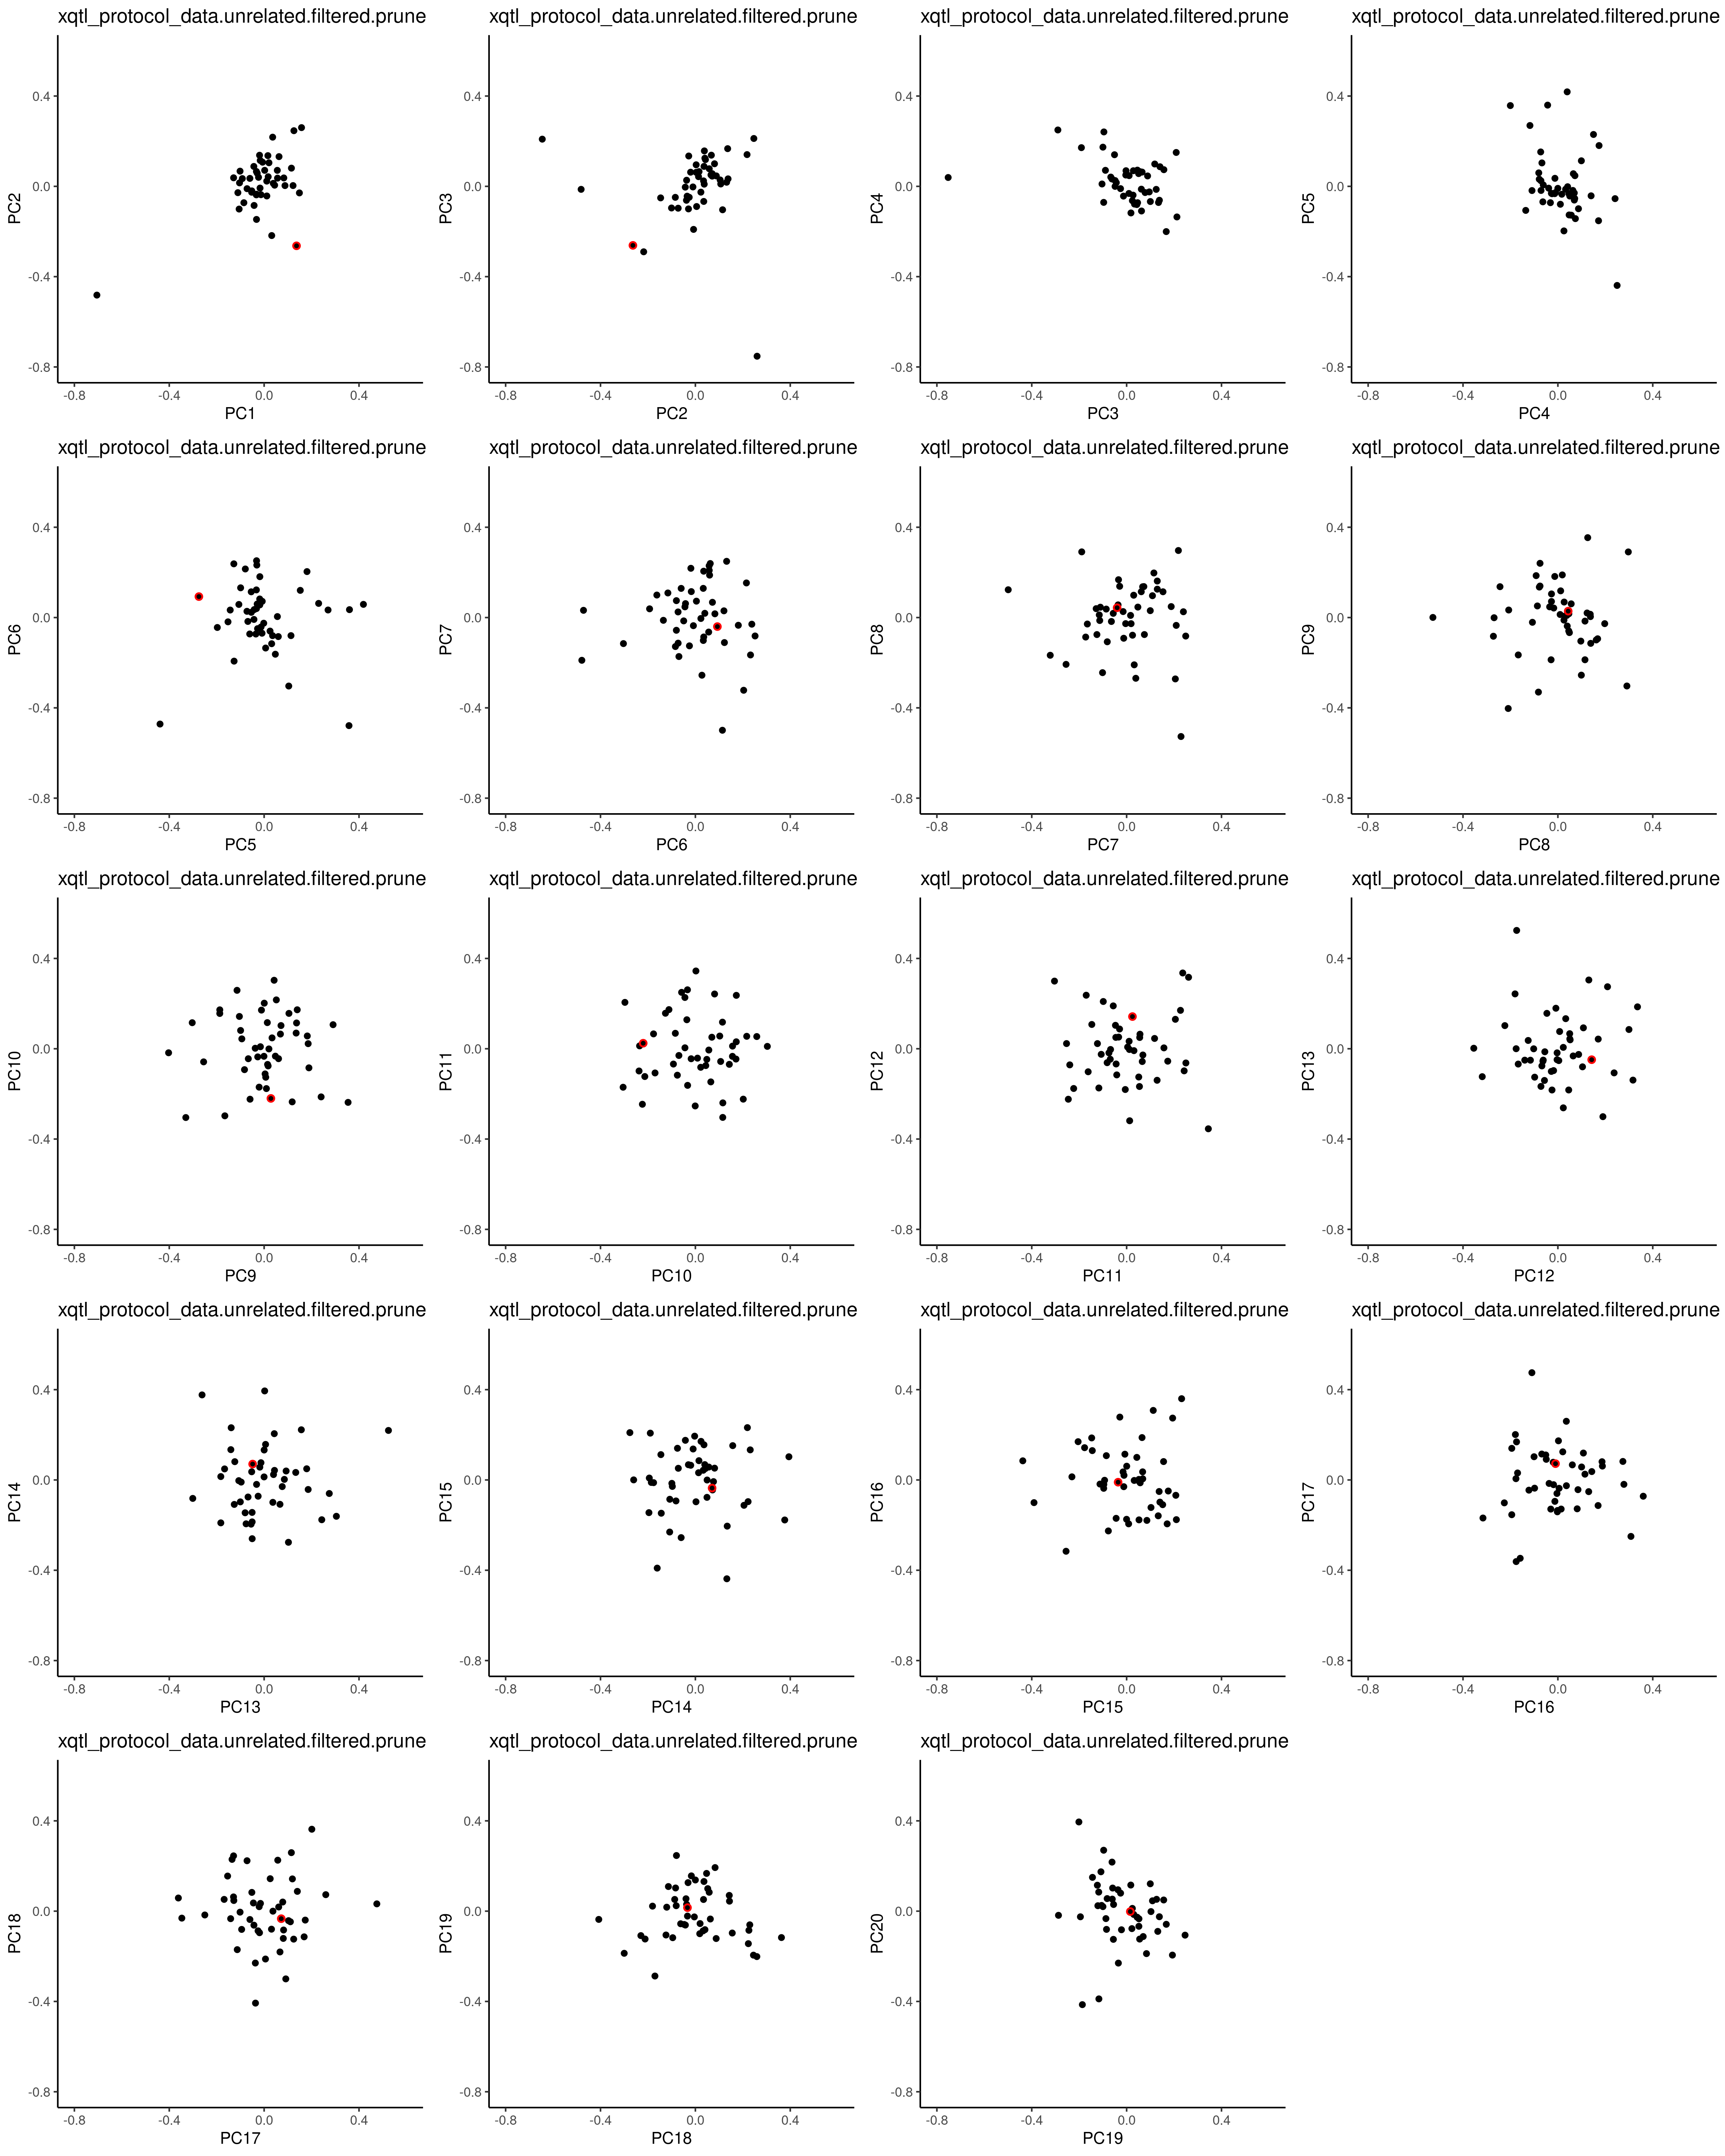

In [2]:
%preview /mnt/vast/hpc/csg/xqtl_workflow_testing/finalizing/output/pca/xqtl_protocol_data.unrelated.filtered.prune.pca.pc.png

> /mnt/vast/hpc/csg/xqtl_workflow_testing/finalizing/output/pca/xqtl_protocol_data.unrelated.filtered.prune.pca.scree.png (56.6 KiB):

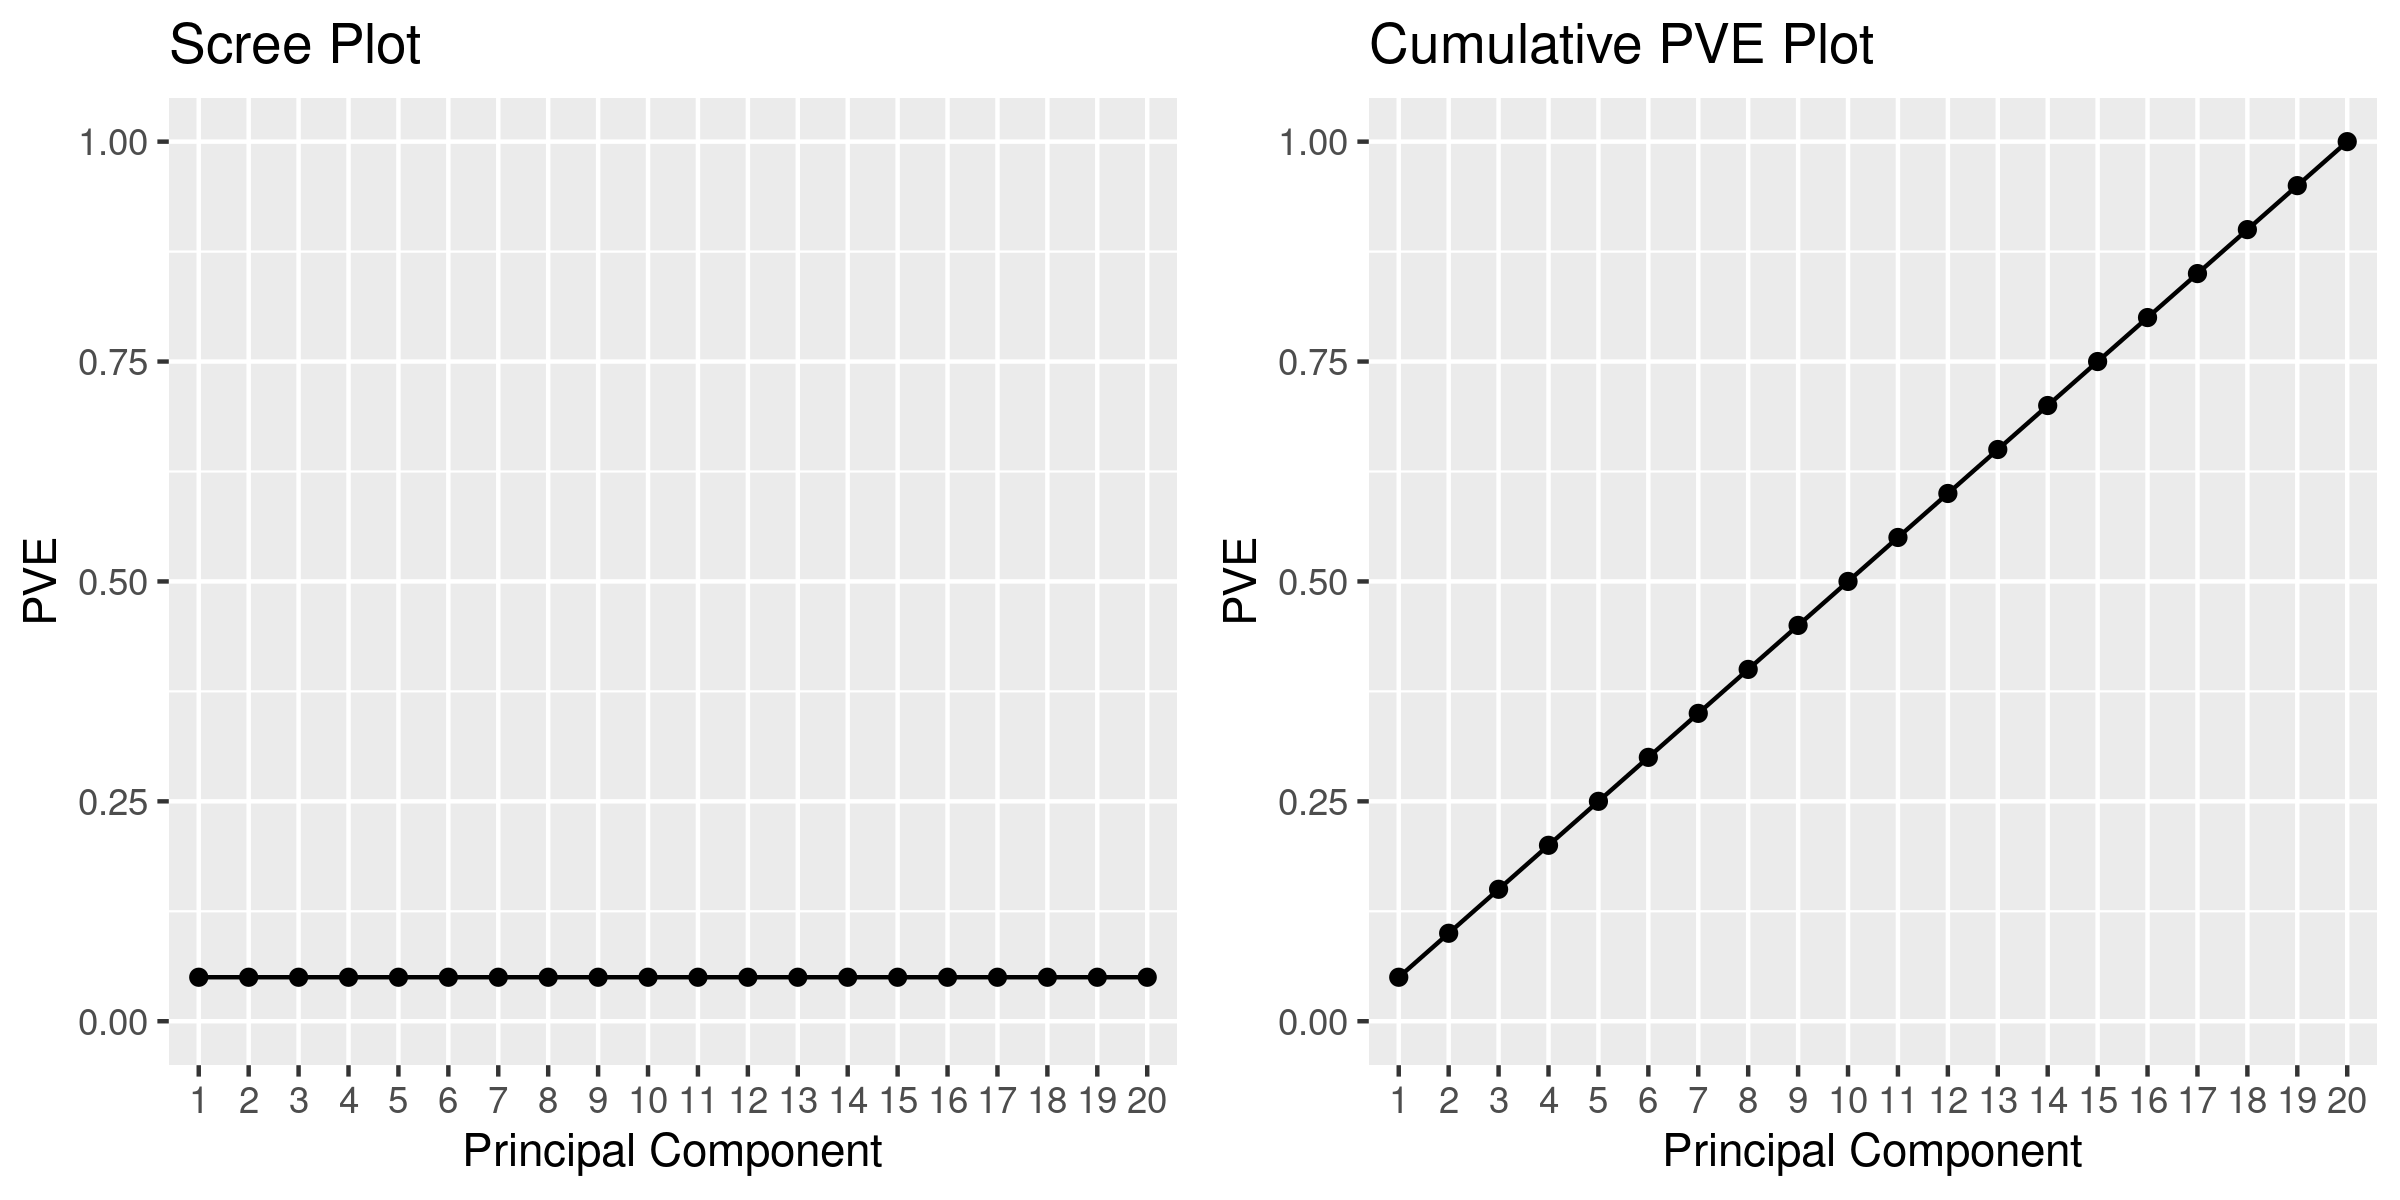

In [5]:
%preview /mnt/vast/hpc/csg/xqtl_workflow_testing/finalizing/output/pca/xqtl_protocol_data.unrelated.filtered.prune.pca.scree.png

Then project back related individuals to the space spanned by PC from unrelated individuals, and detect PC outliers. 

**Notice here that you need to decide how many PCs to use to compute outliers (the `--maha-k` parameter), based on the PC scree plot. You should include a decent number of PCs that capture enough variation in genotype data. Please manually examine the PC plot before running this command.**

In [ ]:
sos run pipeline/PCA.ipynb project_samples \
        --cwd output/pca \
        --genoFile output/genotype/xqtl_protocol_data.related.filtered.extracted.bed  \
        --pca-model  output/pca/xqtl_protocol_data.unrelated.filtered.prune.pca.rds \
        --container containers/flashpcaR.sif --maha-k `awk '$3 < 0.7' output/pca/xqtl_protocol_data.unrelated.filtered.prune.pca.scree.txt  | tail -1 | cut -f 1  ` 

> /mnt/vast/hpc/csg/xqtl_workflow_testing/finalizing/output/pca/xqtl_protocol_data.related.filtered.extracted.pca.projected.pc.png (615.6 KiB):

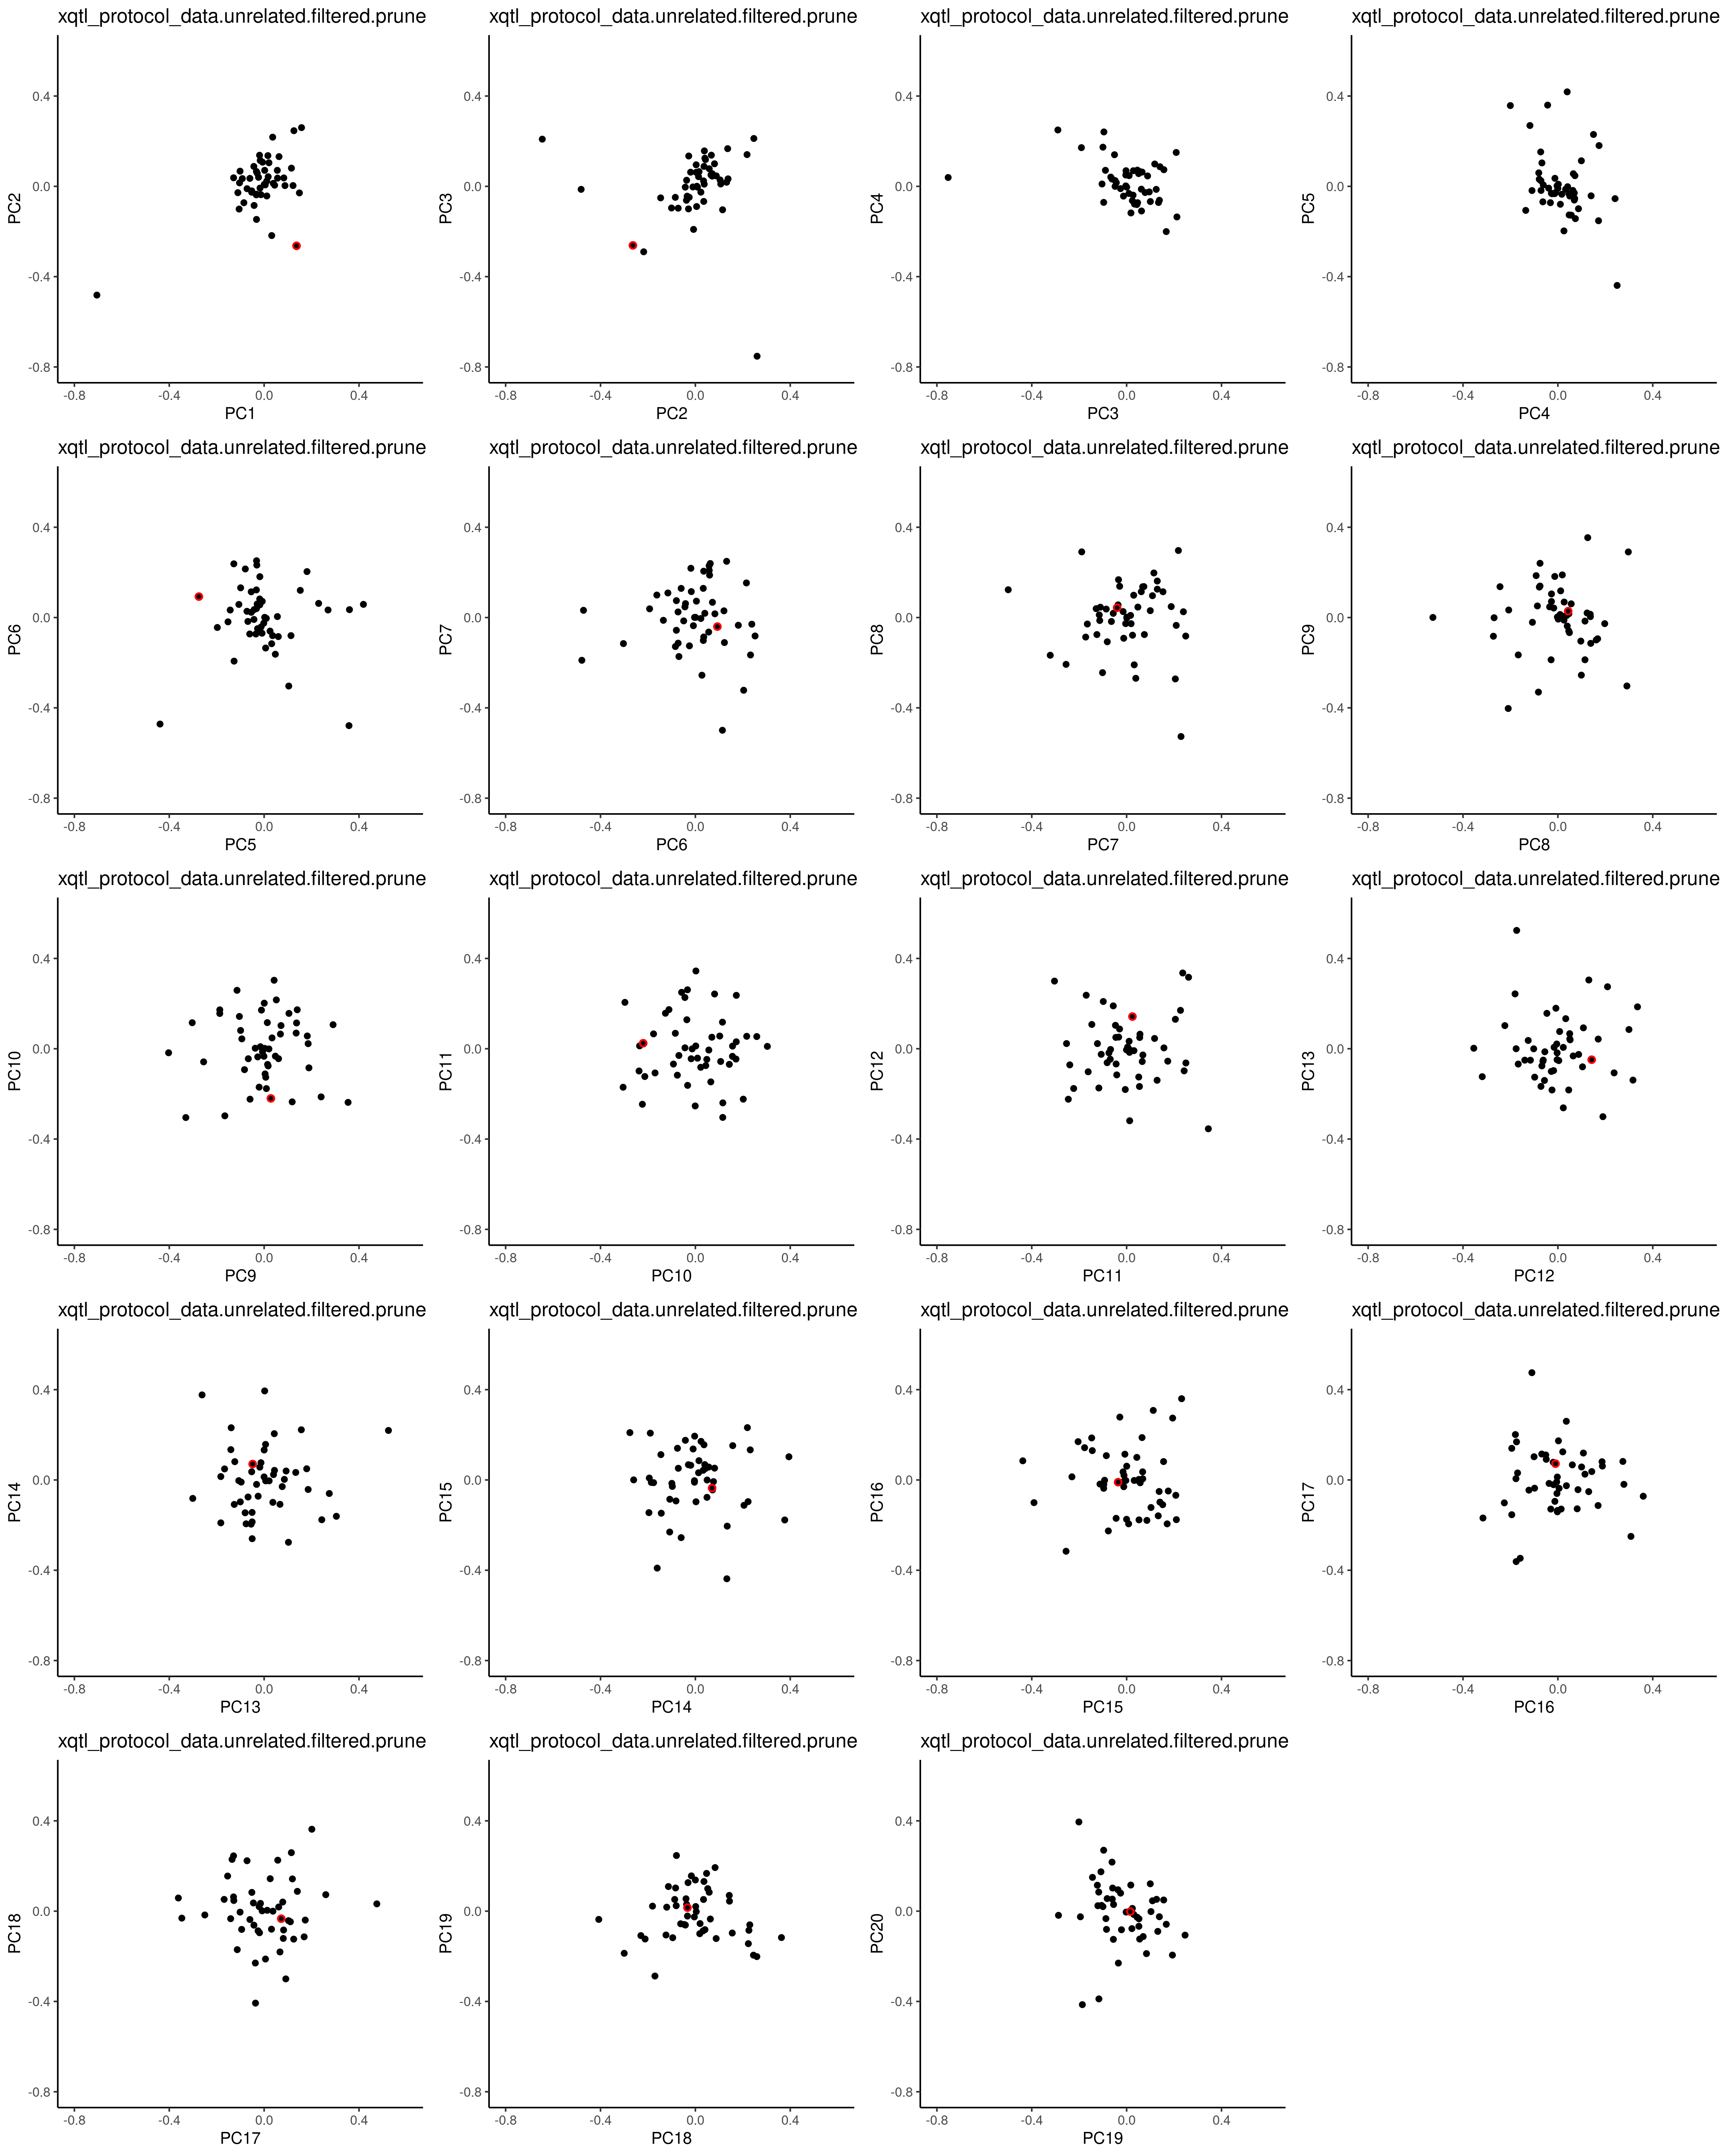

In [6]:
%preview /mnt/vast/hpc/csg/xqtl_workflow_testing/finalizing/output/pca/xqtl_protocol_data.related.filtered.extracted.pca.projected.pc.png

Two outliers was removed, as shown below

In [1]:
cat /mnt/vast/hpc/csg/xqtl_workflow_testing/finalizing/output/pca/xqtl_protocol_data.unrelated.filtered.prune.pca.outliers

0	SM-CJGN1


## Finalized genotype QC
### For common and infrequent variants
In our demo, we only keep variants having sample minor allele count MAC >= 5, for the sake of convenience focusing our single variant analysis. It should be noted that mac and maf don't overwrite each other within our module. It is up to plink to decide how to handle the secnario of both `--maf-filter` and `--mac-filter` > 0. Therefore, the user should not specify both `--maf-filter` and `--mac-filter` without good reason.

In [ ]:
Resource Usage
1. Time elapsed: 14s
2. Max Vmem: 0.4G
    

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
   --cwd output/genotype \
   --genoFile output/genotype/xqtl_protocol_data.bed \
   --geno-filter 0.1 \
   --mind-filter 0.1 \
   --hwe-filter 1e-06   \
   --mac-filter 5 \
   --container containers/bioinfo.sif  \
   --mem 40G

### Optional: Remove outlier

PCA analysis (see covariate formatting page) can possibly provide us a list of outlier samples to be removed from the genotype data. We can optionally remove them and perform genotype data QC.

Removal of samples is a complicated decision that require human descretion. Therefore outlier removal is not performed automatically. The `--remove-samples` parameter take a two columns table that illustrated by  `output/pca/xqtl_protocol_data.related.filtered.extracted.pca.projected.outliers`

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
    --cwd output/genotype \
    --genoFile output/genotype/xqtl_protocol_data.bed \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe-filter 1e-06   \
    --mac-filter 5 \
    --container containers/bioinfo.sif  \
    --mem 40G
    --remove-samples output/pca/xqtl_protocol_data.related.filtered.extracted.pca.projected.outliers



To fully illustrate how PCA and PCA based QC is done on sample with **multiple populations (a more complicated but potentially very useful setting)**, please try out the example documented in the [PCA analysis module](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/PCA.html) with a different example data-set.

### Optional: Extract common variants

In case you would like to focus on common variants only, the genotype data can also filtered by the criteria of missingness > 10% and MAF>5% as shown below to retain the common variants, User can detemined the level of filtering by changing the generated command manually.

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
   --cwd output/genotype \
   --genoFile output/genotype/xqtl_protocol_data.bed \
   --geno-filter 0.1 \
   --mind-filter 0.1 \
   --hwe-filter 1e-06   \
   --maf-filter 0.05 \
   --container containers/bioinfo.sif  \
   --mem 40G

If outliers are to be removed, following command could be used:

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
   --cwd output/genotype \
   --genoFile output/genotype/xqtl_protocol_data.bed \
   --geno-filter 0.1 \
   --mind-filter 0.1 \
   --hwe-filter 1e-06   \
   --maf-filter 0.05 \
   --container containers/bioinfo.sif  \
   --mem 40G 

## Genotype Reformatting
### Partition by Chromosome
The association analysis of TensorQTL required the chromosome be seperated by chromosome to allowed for parallel analysis.

In [ ]:
Resource Usage
1. Time elapsed: 24s
2. Max Vmem: 0.2G
    

In [ ]:
sos run pipeline/genotype_formatting.ipynb plink_by_chrom \
    --genoFile output/genotype/xqtl_protocol_data.filtered.bed \
    --cwd output/data_preprocessing \
    --chrom  `cut -f 1  output/genotype/xqtl_protocol_data.filtered.bim  | uniq | sed "s/chr//g"` \
    --container containers/bioinfo.sif 

### Optional: convert to VCF
If association analysis by APEX is needed, following command convert the per-chromosome plink binaray generated above into indexed vcf.gz.

In [ ]:
sos run pipeline/genotype_formatting.ipynb plink_to_vcf \
    --genoFile plink_files_list.txt  \
    --cwd output/data_preprocessing \
    --container containers/bioinfo.sif 